In [1]:
import os
import sys
import pickle

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))
sys.path.append(str(PROJECT_ROOT / 'lib'))
sys.path.append(str(PROJECT_ROOT / 'script'))

from lib.models.standard_sae import AutoEncoder
from lib.models.gated_sae import GatedAutoEncoder
from lib.datasets.synthetic import get_synthetic_dataset
from script.train_label_recovery import ThreeLayerNet

In [2]:
def get_feature_counts(sae, num_dict, activations):
    n_samples = len(activations)
    feature_counts = torch.zeros(n_samples, num_dict)
    for s in tqdm(range(n_samples), "Counting features"):
        sample = activations[s].to('cuda')
        _, features = sae(sample, output_features=True)
        feature_counts[s] = torch.sum(features, dim=0).detach().cpu()
    return feature_counts

In [3]:
# load synthetic dataset
synthetic_dataset = get_synthetic_dataset()

# get indices of big and small categories
big_category_indices = {}
small_category_indices = {}
for i, row in enumerate(synthetic_dataset):
    big_category = row['big_category']
    small_category = row['small_category']
    if big_category not in big_category_indices:
        big_category_indices[big_category] = []
    if small_category not in small_category_indices:
        small_category_indices[small_category] = []
    big_category_indices[big_category].append(i)
    small_category_indices[small_category].append(i)


In [4]:
# init settings
output_dir = PROJECT_ROOT / 'outputs'
device = torch.device('cuda')
sae_version = 'gated'
q = 2

In [5]:
# load activations
activation_dataset = 'synthetic'
activations_path = output_dir / f'activations_exaone-8b_{activation_dataset}.pkl'
with open(activations_path, 'rb') as fpi:
    activations = pickle.load(fpi)
activations = activations[f'{activation_dataset}_residual_q{q}']

In [6]:
# load AE
sae_dataset = 'keat-ko'
sae_path = output_dir / f'sae-{sae_version}_exaone-8b_{sae_dataset}_q{q}'
if sae_version == 'standard':
    ae = AutoEncoder.from_pretrained(f'{sae_path}/model.pth')
elif sae_version == 'gated':
    ae = GatedAutoEncoder.from_pretrained(f'{sae_path}/model.pth')
ae.to(device)

GatedAutoEncoder(
  (encoder): Linear(in_features=4096, out_features=100000, bias=False)
  (decoder): Linear(in_features=100000, out_features=4096, bias=False)
)

In [7]:
# get feature counts
num_dict = ae.dict_size
feature_counts = get_feature_counts(ae, num_dict, activations)
del ae
torch.cuda.empty_cache()

Counting features:   0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
num_data, num_dict = feature_counts.shape
print(f"num data: {num_data}")
print(f"num dict: {num_dict}")

num data: 1500
num dict: 100000


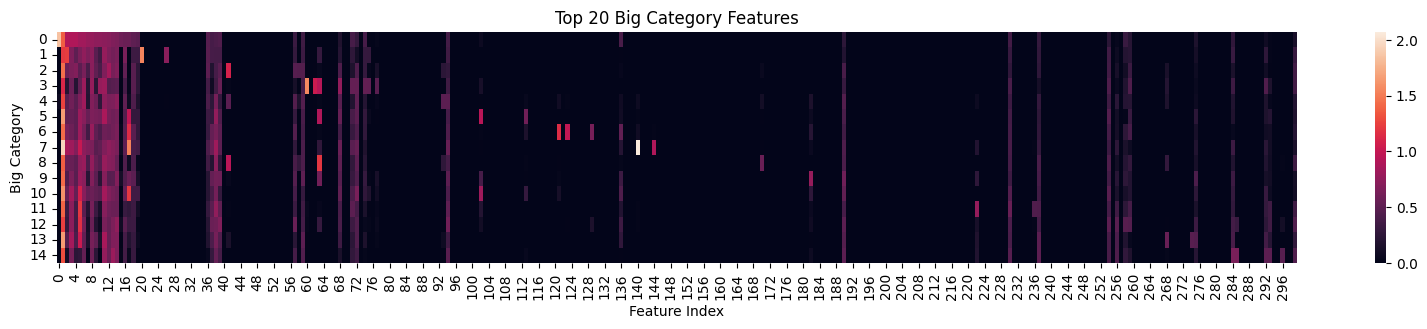

<Figure size 640x480 with 0 Axes>

In [9]:
top_k = 20

all_indices = []
category_top_k_indices = {}
category_top_k_values = {}
category_means = {}
all_mean = feature_counts.mean(dim=0)
for category, indices in big_category_indices.items():

    # select samples
    selected_feature_counts = feature_counts[indices]
    mean = torch.mean(selected_feature_counts, dim=0)

    # select top k features
    top_k_results = torch.topk(mean, k=top_k, dim=0)
    top_k_mean_indices = top_k_results.indices

    # gather indices
    all_indices.extend(top_k_mean_indices.tolist())
    category_top_k_indices[category] = top_k_mean_indices.tolist()
    category_means[category] = mean.tolist()

# prepare heatmap data
heatmap_data = np.zeros((len(big_category_indices.keys()), len(all_indices)))
for i, (category, indices) in enumerate(category_top_k_indices.items()):
    for j in all_indices:
        j_hat = all_indices.index(j)  # don't use raw feature index; use remapped version
        heatmap_data[i, j_hat] = category_means[category][j]

# plot heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data)
plt.title(f"Top {top_k} Big Category Features")
plt.xlabel("Feature Index")
plt.ylabel("Big Category")
plt.show()

# save heatmap
asset_dir = PROJECT_ROOT / 'assets'
plt.savefig(asset_dir / f'top-{top_k}_big-category_features.png', dpi=300, bbox_inches='tight')

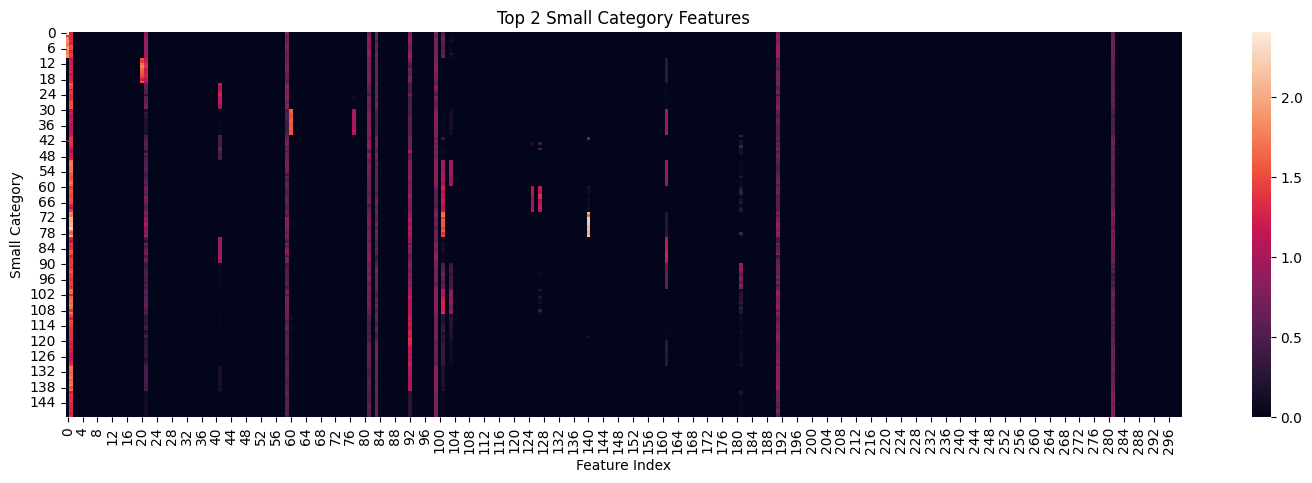

<Figure size 640x480 with 0 Axes>

In [10]:
top_k = 2

all_indices = []
category_top_k_indices = {}
category_top_k_values = {}
category_means = {}
all_mean = feature_counts.mean(dim=0)
for category, indices in small_category_indices.items():

    # select samples
    selected_feature_counts = feature_counts[indices]
    mean = torch.mean(selected_feature_counts, dim=0)

    # select top k features
    top_k_results = torch.topk(mean, k=top_k, dim=0)
    top_k_mean_indices = top_k_results.indices

    # gather indices
    all_indices.extend(top_k_mean_indices.tolist())
    category_top_k_indices[category] = top_k_mean_indices.tolist()
    category_means[category] = mean.tolist()

# prepare heatmap data
heatmap_data = np.zeros((len(small_category_indices.keys()), len(all_indices)))
for i, (category, indices) in enumerate(category_top_k_indices.items()):
    for j in all_indices:
        j_hat = all_indices.index(j)  # don't use raw feature index; use remapped version
        heatmap_data[i, j_hat] = category_means[category][j]

# plot heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(heatmap_data)
plt.title(f"Top {top_k} Small Category Features")
plt.xlabel("Feature Index")
plt.ylabel("Small Category")
plt.show()

plt.savefig(asset_dir / f'top_{top_k}_small_category_features.png', dpi=300, bbox_inches='tight')

In [11]:
# prepare data
data = np.zeros((len(synthetic_dataset), len(all_indices)))
for index in range(len(synthetic_dataset)):
    data[index] = np.asarray(feature_counts[index, all_indices])

In [12]:
# prepare labels
small_categories = list(small_category_indices.keys())
labels2lindex = {label: lindex for lindex, label in enumerate(small_categories)}
lindices = [labels2lindex[row['small_category']] for row in synthetic_dataset]
lindices = np.array(lindices)

In [13]:
# convert data to PyTorch tensors
X = torch.FloatTensor(data)
y = torch.LongTensor(lindices)

# initialize model, loss, optimizer
input_size = X.shape[1]
num_classes = len(small_categories)
model = ThreeLayerNet(input_size, depth=3, num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop
epochs = 500
losses = []
for epoch in tqdm(range(1, epochs + 1)):
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())

  0%|          | 0/500 [00:00<?, ?it/s]

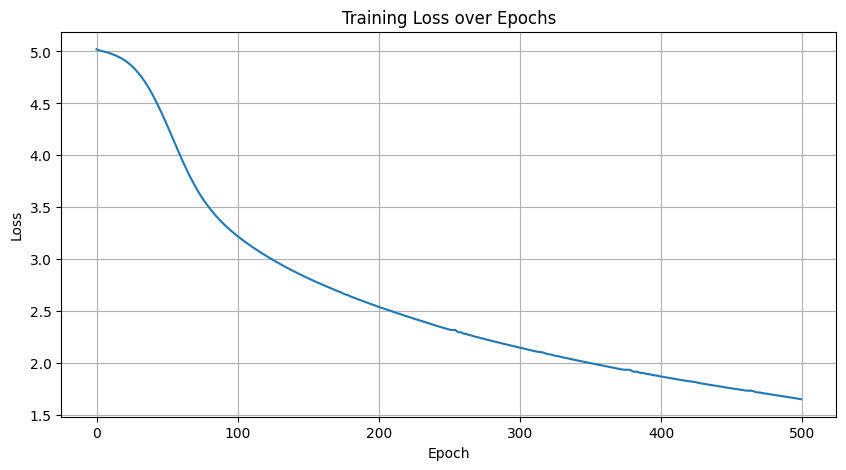

Final accuracy: 0.5047


In [14]:
# plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# calculate accuracy
with torch.no_grad():
    logits = model(X)
    _, y_hat = torch.max(logits.data, 1)
    accuracy = (y_hat == y).sum().item() / y.size(0)
    print(f"Final accuracy: {accuracy:.4f}")